<img src="./pics/DL.png" width=110 align="left" style="margin-right: 10px">

# Introduction to Deep Learning

## 05. Home Assignment I.

---

## Silent MNIST

<p><a href="https://commons.wikimedia.org/wiki/File:%D9%84%D8%BA%D8%A9_%D8%A7%D9%84%D8%A7%D8%B4%D8%A7%D8%B1%D8%A9_%D8%A7%D9%84%D8%A7%D9%85%D8%B1%D9%8A%D9%83%D9%8A%D8%A9.png#/media/File:لغة_الاشارة_الامريكية.png"><img src="./pics/exercises/silent_mnist.png" width=400></a><br>By <a href="//commons.wikimedia.org/w/index.php?title=User:Krzys_kurd&amp;action=edit&amp;redlink=1" class="new" title="User:Krzys kurd (page does not exist)">Krzys kurd</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=24699115">Link</a></p>

### Description

Create a silent number detector using the different pictures taken of the signers hands. Your task is to create a neural network to solve this problem, using dense layers. You are free to use any kind of preprocessing or any kind of transformation on the data, and you can use any discussed methods.  
Your designed solution must be presented in a form of clean, structured and well commented code. Descriptions should include the designed network layouts and the reasoning behind the choices. The final results should be highlighted, saved ([tutorial](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)) and easily reproduceable.  
Creating parametrizable functions to dynamically generate networks is a plus.

### About the data

The pictures are already preprocessed and transformed into greyscale image matrices.  
The target variable is the value of the associated sign in one-hot encoded form.  
Both feature matrix and target vectors are available as numpy arrays and can be found in the `data/sign_language/` folder. You can read `.npy` numpy array files with the `np.load("path_to_file.npy")` function.

### Table of Contents

* [Import libraries](#import-libraries)
  * [Set the seed](#set-seed)
* [Load and explore the dataset](#load-and-explore)
* [Network layout](#network-layout)
  * [Train-test split](#train-test-split)
  * [Create a baseline network](#create-baseline)
  * [Create multiple possible networks](#multiple-networks)
  * [Compare models](#compare-models)
* [Save the best performing network](#save-network)

### Import libraries <a class="anchor" id="import-libraries"></a>

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import os
import random
import tensorflow as tf
import pandas as pd

#### Set the seed <a class="anchor" id="set-seed"></a>

In [2]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

### Load and explore the dataset <a class="anchor" id="load-and-explore"></a>

In [3]:
X = np.load('data/sign_language/X.npy')
y = np.load('data/sign_language/y.npy')

In [4]:
print('Shape of X:', X.shape, '\nNumber of observations:', len(X))

Shape of X: (2062, 64, 64) 
Number of observations: 2062


We have 2062 observations in our dataset. Let's start exploring these by looking at one of the X values and its shape:

In [5]:
print('Array of values for X[0]:\n', X[0], '\n\nShape of X[0]:', X[0].shape)

Array of values for X[0]:
 [[0.47450978 0.46274507 0.45098037 ... 0.50196075 0.5137255  0.52549016]
 [0.46666664 0.45098037 0.43921566 ... 0.4980392  0.5098039  0.52156866]
 [0.45490193 0.43921566 0.42745095 ... 0.49411762 0.50196075 0.517647  ]
 ...
 [0.4470588  0.4352941  0.4235294  ... 0.49019605 0.4980392  0.5058824 ]
 [0.45490193 0.44313723 0.43137252 ... 0.4980392  0.5058824  0.5137255 ]
 [0.46274507 0.45098037 0.43921566 ... 0.50196075 0.5098039  0.52156866]] 

Shape of X[0]: (64, 64)


So we have 64x64 pixel images, and each pixel's greyscale value is between 0 and 1. In order for Keras to be able to consume this data, I have to flatten the matrix for each image.

In [6]:
input_dim = 64 * 64

X = X.flatten().reshape(len(X), input_dim)
print('Shape of X:', X.shape)

Shape of X: (2062, 4096)


Let's see what value the matrix for `X[0]` represents:

In [7]:
print('y[0] in one-hot encoded form:', y[0], '\n\nShape of y[0]:', y[0].shape)

y[0] in one-hot encoded form: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

Shape of y[0]: (10,)


Based on the labels, this particular image should show a 0. 

Let's add a few other observations and see if our expectation meets what's actually shown in the images.

In [8]:
y_items = [0, 50, 500, 1000]
for i in y_items:
    print('y[{}] in one-hot encoded form:'.format(i), y[i])

y[0] in one-hot encoded form: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
y[50] in one-hot encoded form: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
y[500] in one-hot encoded form: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
y[1000] in one-hot encoded form: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


Which means we're expecting to see images of hands signing two 0s, a 2 and a 4.

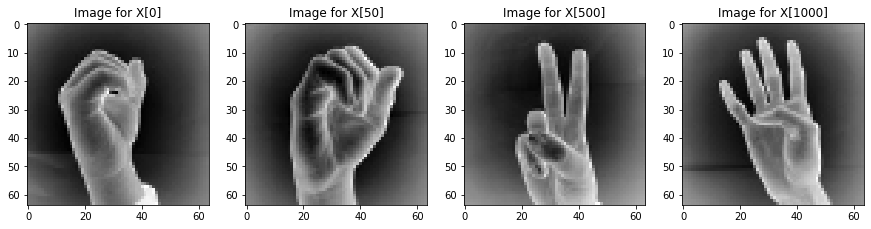

In [9]:
f, ax = plt.subplots(nrows=1, ncols=len(y_items), figsize=(15, 15))
for i in y_items:
    pos = y_items.index(i)  
    ax[pos].imshow(X[i].reshape(64, 64), cmap=plt.get_cmap('gray'))
    ax[pos].title.set_text('Image for X[{}]'.format(i))

Our assumption was correct, we can see two zeros, a 2 and a 4. 

Now that we have a pretty good idea what our data looks like, we can get to building our network.

### Network layout <a class="anchor" id="network-layout"></a>

#### Create train-test (75-25%) split <a class="anchor" id="train-test-split"></a>

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed_value)

#### Create a baseline network <a class="anchor" id="create-baseline"></a>

I worked with the MNIST dataset as part of an assignment for _Data Science 3: Machine Learning Tools_ earlier this year ([GitHub repo](https://github.com/szigony/ceu-ds3/blob/master/DS3_A2_Patrik-Szigeti.Rmd)), and I was able to achieve 88.7% prediction accuracy. Since it's generally a good practice to learn from ourselves, I'll use the specifications of my previously built model, and I'll try to see if I can improve upon that score. For my base model I'm using one dense layer with 128 units followed by a dropout layer with `rate=0.3`.

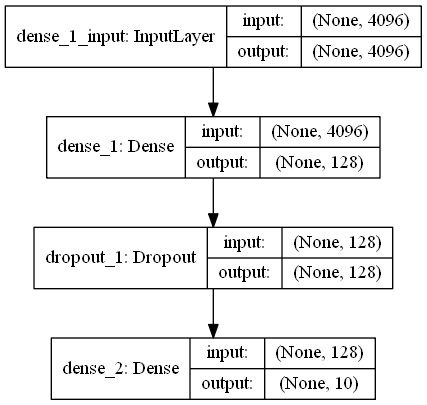

In [11]:
output_dim = 10

model_bl = Sequential()
model_bl.add(Dense(units=128, input_dim=input_dim, activation='relu'))
model_bl.add(Dropout(rate=0.3))
model_bl.add(Dense(units=output_dim, activation='softmax'))

plot_model(model_bl, show_shapes=True, show_layer_names=True)

In [12]:
model_bl.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

model_bl.fit(X_train, y_train, epochs=500, validation_split=0.2, batch_size=64, verbose=False)

model_bl_loss, model_bl_accuracy = model_bl.evaluate(X_test, y_test, verbose=False)
print(f'The accuracy of the baseline model on the test set is {model_bl_accuracy:.2%}')

# Create a dictionary to store models and their performance for comparison
model_accuracies = {}
model_accuracies.update({'model_bl': {'model': model_bl, 'accuracy': model_bl_accuracy}})

The accuracy of the baseline model on the test set is 49.22%


#### Create multiple possible networks <a class="anchor" id="multiple-networks"></a>

In order to dynamically test multiple possible networks, I created several parameterizable functions:
* `network_build`: Builds a dynamic dense network based on the specifications. It allows for specifying the number of dense layers and the number of units in them, the input and output dimensions, whether to include dropout layers after each dense layer or not, and the activation function. There is some custom error handling built in to ensure the correct parameters are given.
* `compile_fit_evaluate_network`: Compiles the model, fits it on the train set and evaluates its accuracy against the test set. In order to ensure reproducibility, we can specify the number of repeats as well (idea based on Jason Brownlee's article, [How to Get Reproducible Results with Keras](https://machinelearningmastery.com/reproducible-results-neural-networks-keras/)), and the final metric will be the grand mean, which is the average calculated from the separate run's accuracies. You can also specify the number of epochs, the validation split, batch size, as well as the loss function and optimizer to be used.

In [13]:
def network_build(dense_layers=1, dense_units=[128], input_dim=input_dim, dropout_layers=True, dropout_ratio=[0.3], 
                  activation='relu', output_dim=output_dim):
    '''This function builds a dynamic dense network based on the provided inputs.'''
    
    # Error handling
    if dense_layers != len(dense_units):
        raise ValueError('The length of the dense_units array must be equal to the number of dense layers.')
    if dropout_layers:
        if len(dropout_ratio) == 0:
            raise ValueError('If you want to include dropout layers, you must provide an array of dropout ratios.')
        if len(dropout_ratio) != 0 and len(dense_units) != len(dropout_ratio):
            raise ValueError('The number of dropout layers must be the same as the number of dense layers.')
        
    # Model building
    model = Sequential()
    for i in range(0, dense_layers):
        model.add(Dense(units=dense_units[i], input_dim=input_dim, activation=activation))
        if dropout_layers:
            model.add(Dropout(rate=dropout_ratio[i]))
    model.add(Dense(units=output_dim, activation='softmax'))
      
    return model

In [37]:
def compile_fit_evaluate_network(model, X_train, y_train, X_test, y_test, epochs=100, validation_split=0.2, batch_size=64, 
                                 loss_function='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'], 
                                 num_of_repeats=10):
    '''This function compiles the model, fits it on the train set and evaluates its accuracy against the test set. It also 
    repeats the experiment a selected number of times and takes the average of their accuracy as the final metric, 
    also known as grand average.'''
    
    # Error handling
    if type(loss_function) != str:
        raise ValueError('You must only provide one loss function.')
    
    # Network building
    accuracies = []
    for i in range(0, num_of_repeats):
        # Compile the model
        model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)

        # Fit the model
        model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, batch_size=batch_size, verbose=False)

        # Evaluate the model on the test set
        model_loss, model_accuracy = model.evaluate(X_test, y_test, verbose=False)
        accuracies.append(model_accuracy)
    
    grand_mean = np.mean(accuracies)
    print(f'The overall accuracy of the model on the test set is {grand_mean:.2%}')
        
    return model, grand_mean

`model_1`: Compared to my baseline model, I'm not using dropout layers to minimize the randomness of the outcome, and I'm using two dense layers (in addition to the final layer), starting with a size of 512, followed by a layer with 128 neurons.

In [15]:
m1_model, m1_accuracy = compile_fit_evaluate_network(
    model=network_build(
        dense_layers=2,
        dense_units=[512, 128],
        dropout_layers=False
    ),
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)

model_accuracies.update({'model_1': {'model': m1_model, 'accuracy': m1_accuracy}})

The overall accuracy of the model on the test set is 80.31%


`model_2`: For my second model, I kept the specifications of `model_1`, but changed the activation function from `relu` to `tanh`. Several articles and Stackoverflow topics discussed its usage, so I wanted to see how well it would perform in this case.

In [16]:
m2_model, m2_accuracy = compile_fit_evaluate_network(
    model=network_build(
        dense_layers=2,
        dense_units=[512, 128],
        dropout_layers=False,
        activation='tanh'
    ),
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)

model_accuracies.update({'model_2': {'model': m2_model, 'accuracy': m2_accuracy}})

The overall accuracy of the model on the test set is 79.32%


`model_3`: To experiment with dropout layers, for my third model, I'll include two: one with 0.3 ratio and one with 0.1 ratio after the dense layers that were tried and tested for `model_2`.

In [17]:
m3_model, m3_accuracy = compile_fit_evaluate_network(
    model=network_build(
        dense_layers=2,
        dense_units=[512, 128],
        dropout_layers=True,
        dropout_ratio=[0.3, 0.1]
    ),
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)

model_accuracies.update({'model_3': {'model': m3_model, 'accuracy': m3_accuracy}})

The overall accuracy of the model on the test set is 78.43%


`model_4`: I'll revert back from dropout layers, as it seems to introduce unwanted randomness in the network. Instead I'll try to introduce a third dense layer with smaller number of neurons.

In [39]:
m4_model, m4_accuracy = compile_fit_evaluate_network(
    model=network_build(
        dense_layers=3,
        dense_units=[512, 128, 32],
        dropout_layers=False
    ),
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)

model_accuracies.update({'model_4': {'model': m4_model, 'accuracy': m4_accuracy}})

The overall accuracy of the model on the test set is 81.55%


`model_5`: Sticking to the three dense layers (in addition to the final one), but instead of using the `RMSprop` optimizer, I'll try `Adam`. Based on my previous attempts at building networks, I found that `RMSprop` performs better, but there are several articles that refer to `Adam` as the better choice, and I wanted to see how it would perform for this problem.

In [40]:
m5_model, m5_accuracy = compile_fit_evaluate_network(
    model=network_build(
        dense_layers=3,
        dense_units=[512, 128, 32],
        dropout_layers=False
    ),
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    optimizer=Adam()
)

model_accuracies.update({'model_5': {'model': m5_model, 'accuracy': m5_accuracy}})

The overall accuracy of the model on the test set is 76.07%


#### Compare models <a class="anchor" id="compare-models"></a>

I'm comparing the grand means of my six models to determine which one performed best, and which one to save for later use.

In [41]:
df_model_accuracies = pd.DataFrame(data=model_accuracies).T
df_model_accuracies

,model,accuracy
model_bl,<keras.engine.sequential.Sequential object at ...,0.492248
model_1,<keras.engine.sequential.Sequential object at ...,0.803101
model_2,<keras.engine.sequential.Sequential object at ...,0.793217
model_3,<keras.engine.sequential.Sequential object at ...,0.784302
model_4,<keras.engine.sequential.Sequential object at ...,0.815504
model_5,<keras.engine.sequential.Sequential object at ...,0.760659


In [42]:
highest_accuracy = max(df_model_accuracies['accuracy'])
highest_accuracy_model = ''.join(df_model_accuracies[df_model_accuracies['accuracy'] == highest_accuracy].index.tolist())
               
print('The highest accuracy is ' + '{:.2%}'.format(highest_accuracy) + ', which belongs to ' + highest_accuracy_model + '.')

The highest accuracy is 81.55%, which belongs to model_4.


### Save the best performing network <a class="anchor" id="save-network"></a>

In [43]:
df_model_accuracies.loc[highest_accuracy_model]['model'].save('best_performing_network.h5')